# Build a BP  neural network

## 1 import dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [3]:
data = loadmat("ex4data1.mat")
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [17]:
X = data["X"]
y = data["y"]
X.shape, y.shape

((5000, 400), (5000, 1))

In [18]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False, categories="auto")
y_onehot = encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

In [19]:
y[0], y_onehot[0, :]

(array([10], dtype=uint8), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

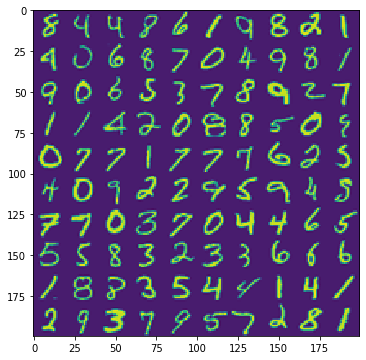

In [13]:
import random
#将400 转为 20*20图像
def getImg(row):
    width, height = 20, 20
    square = row.reshape(width, height)
    return square.T

#展示图像
def displayImg(indices_to_display = None):
    width, height = 20, 20
    nrows, ncols = 10, 10
    if indices_to_display == None:
        indices_to_display = random.sample(range(X.shape[0]), nrows * ncols)
    big_picture = np.zeros((height * nrows, width * ncols))
    irow , icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol = 0
        iimg = getImg(X[idx])
        big_picture[(irow * height):(irow * height + iimg.shape[0]),
                   (icol * width):(icol * width +iimg.shape[1])] = iimg
        icol += 1
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(big_picture,interpolation='nearest')
displayImg()

## 2 Import weights

In [27]:
weights = loadmat("ex4weights.mat")
theta1, theta2 = weights["Theta1"], weights["Theta2"]
theta1.shape, theta2.shape

((25, 401), (10, 26))

## 3 Sigmod

In [14]:
def sigmod(z):
    return 1 / (1 + np.exp(-z))

## 4 Forward_propagate

In [32]:
def forward_propagate(Xi, theta1, theta2):
    # theta1  (25, 401) theta2 (10, 26)
    a1 = np.insert(Xi.reshape((Xi.shape[0], 1)), 0, 1, axis=0) # (401, 1)
    z2 = theta1 @ a1 # (25, 1)
    a2 = np.insert(sigmod(z2), 0, 1, axis=0) #(26, 1)
    z3 = theta2 @ a2 # (10, 1)
    h = sigmod(z3) # (10, 1)
    return a1, z2, a2, z3, h

In [33]:
a1, z2, a2, z3, h = forward_propagate(X[0], theta1, theta2)
a1.shape, z2.shape, a2.shape, z3.shape, h.shape

((401, 1), (25, 1), (26, 1), (10, 1), (10, 1))

##  5 Initial values

In [40]:
input_size = 400
hidden_size = 25
output_size = 10
learning_rate = 1.
weights_size = (input_size + 1) * hidden_size + (hidden_size + 1) * output_size
params = (np.random.random(size=weights_size) - 0.5) * 0.25


## 6 Reshape params to theta

In [41]:
def reshapeParams(params):
    theta1 = params[:hidden_size * (input_size + 1)].reshape((hidden_size, input_size + 1))
    theta2 = params[hidden_size * (input_size + 1):].reshape((output_size, hidden_size + 1))
    return theta1, theta2


## 7 Cost function

In [43]:
def cost(params, input_size, hidden_size, output_size, X, y, learning_rate = 0.):
    m = X.shape[0]
    theta1, theta2 = reshapeParams(params)
    J = 0.
    for i in range(m):
        a1, z2, a2, z3, h = forward_propagate(X[i], theta1, theta2)
        tempy = y[i,:].reshape((output_size, 1))
        first_term = tempy * np.log(h) # (10, 1)
        second_term = (1 - tempy) * np.log(1 - h) # (10, 1)
        J += -np.sum(first_term + second_term)
    
    J /= m
    
    # add the regulartion term
    J += (float(learning_rate) / (2 * m)) * \
    (np.sum(theta1[:, 1:] ** 2) + np.sum(theta2[:, 1:] ** 2))
    return J

In [92]:
cost(params, input_size, hidden_size, output_size, X, y_onehot, learning_rate)

6.8014789992509685

## 8 Sigmod gradient 

In [47]:
def sigmodGradient(z):
    t = sigmod(z)
    return t * (1 - t)

## 9 Backpropagate

In [60]:
def backpropagate(params, input_size, hidden_size, output_size, X, y, learning_rate):
    m = X.shape[0]
    theta1, theta2 = reshapeParams(params)
    
    J = 0.
    delta1 = np.zeros(theta1.shape) # (25, 401)
    delta2 = np.zeros(theta2.shape) # (10, 26)
    
    for i in range(m):
        a1, z2, a2, z3, h = forward_propagate(X[i], theta1, theta2)
        tempy = y[i,:].reshape((output_size, 1)) # (10, 1)
        first_term = tempy * np.log(h) # (10, 1)
        second_term = (1 - tempy) * np.log(1 - h) # (10, 1)
        
        J += -np.sum(first_term + second_term)
        
        dt3 = h - tempy # (10, 1)
        
        tempz2 = np.insert(z2, 0, 1, axis=0) #(26, 1)
        dt2 = theta2.T @ dt3 * sigmodGradient(tempz2) # (26, 1)
        
        delta1 += dt2[1:] @ a1.T 
        delta2 += dt3 @ a2.T 
    delta1 /= m
    delta2 /= m
    J /= m
    J += (float(learning_rate) / (2 * m)) * (np.sum(theta1[:, 1:] ** 2) + np.sum(theta2[:, 1:] ** 2))
    delta1[:, 1:] = delta1[:, 1:] + (theta1[:, 1:] * learning_rate) / m
    delta2[:, 1:] = delta2[:, 1:] + (theta2[:, 1:] * learning_rate) / m
    
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    return J, grad

In [61]:
J, grad = backpropagate(params, input_size, hidden_size, output_size, X, y_onehot, learning_rate)
J, grad.shape

(6.8014789992509685, (10285,))

## 10 Gradient checking

In [84]:
def checkGradient(params, grad, input_size, hidden_size, 
                  output_size, X, y, leraning_rate):
    eps = 1e-4
    n = len(params)
    for i in range(10):
        x = random.randint(0, n - 1)
        epsvec = np.zeros(n)
        epsvec[x] = eps
        cost_high = cost(params + epsvec, input_size, 
                         hidden_size, output_size, X, y, learning_rate)
        cost_low = cost(params - epsvec, input_size, 
                         hidden_size, output_size, X, y, learning_rate)
        mygrad = (cost_high - cost_low) / (2 * eps)
        print(f"Element: {x}. Numerical Gradient = {mygrad} BP grad = {grad[x]}")

checkGradient(params, grad, input_size, hidden_size, output_size, X, y_onehot, learning_rate)
#len(grad)

Element: 7755. Numerical Gradient = 0.012584221713574095 BP grad = 0.012584221588317037
Element: 8873. Numerical Gradient = 7.583507155572988e-06 BP grad = 7.583512639370713e-06
Element: 3391. Numerical Gradient = -0.0007342762531337144 BP grad = -0.0007342762945045607
Element: 3055. Numerical Gradient = 0.0011032363911311904 BP grad = 0.0011032362993529145
Element: 510. Numerical Gradient = -0.004595596925227596 BP grad = -0.004595596845110169
Element: 5900. Numerical Gradient = 0.0038248324951695167 BP grad = 0.0038248325690848355
Element: 6911. Numerical Gradient = -0.003817232174796459 BP grad = -0.0038172322287809775
Element: 8510. Numerical Gradient = -0.0005392985658048133 BP grad = -0.0005392986590584643
Element: 5411. Numerical Gradient = -0.00046577056878049916 BP grad = -0.0004657704091798015
Element: 3521. Numerical Gradient = -0.0033600407700618007 BP grad = -0.0033600406954261055


## 11 Training

In [62]:
from scipy.optimize import minimize
fmin = minimize(fun=backpropagate, x0=params, 
                args=(input_size, hidden_size, output_size, X, y_onehot, 0.05),  
               method="TNC", jac=True, options={"maxiter": 250})
fmin

     fun: 0.06518529368682204
     jac: array([-3.78155063e-04,  2.83628969e-07, -8.07452518e-07, ...,
        3.41476960e-05, -3.13285343e-05, -2.01669424e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 23
  status: 3
 success: False
       x: array([ 1.38607714,  0.0283629 , -0.08074525, ..., -7.46527192,
        3.75606978, -2.59803926])

## 12 Compute accuracy

In [63]:
learned_theta1, learned_theta2 = reshapeParams(fmin.x)


In [68]:
def computeAccuracy(X, y, theta1, theta2):
    m = X.shape[0]
    correct = 0
    for i in range(m):
        a1, z2, a2, z3, h = forward_propagate(X[i], theta1, theta2)
        correct += int(np.argmax(h) + 1 == y[i])
    print("accuracy = {0}%".format(100 * correct / m))

In [69]:
# the accuracy of theta1, theta2
computeAccuracy(X, y, theta1, theta2)

accuracy = 97.52%


In [70]:
# the accuracy of learned_theta1, learned_theta2
computeAccuracy(X, y, learned_theta1, learned_theta2)

accuracy = 99.9%


## 13 Visualizing the hidden layer

In [75]:
def displayHiddenLayer(myTheta):
    """
    Function that takes slices of the first Theta matrix (that goes from
    the input layer to the hidden layer), removes the bias unit, and reshapes
    it into a 20x20 image, and shows it
    """
    #remove bias unit:
    myTheta = myTheta[:,1:]
    assert myTheta.shape == (25,400)
    
    width, height = 20, 20
    nrows, ncols = 5, 5
        
    big_picture = np.zeros((height * nrows, width * ncols))
    
    irow, icol = 0, 0
    for row in myTheta:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getImg(row)
        big_picture[irow * height: irow * height + iimg.shape[0], icol * width: icol * width + iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(big_picture,interpolation='nearest')

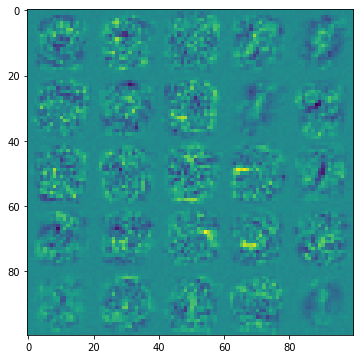

In [76]:
displayHiddenLayer(learned_theta1)

In [101]:
cost(params, input_size, hidden_size, output_size, X, y_onehot, learning_rate)

6.8014789992509685

In [94]:
t1, t2 = reshapeParams(params)
computeAccuracy(X, y, t1, t2)

accuracy = 4.84%


In [100]:
cost(params, input_size, hidden_size, output_size, X[:2,:], y_onehot, learning_rate)

19.865052347924156

In [102]:
theta1.size + theta2.size

10285